In [2]:
from am4pa.linnea import LinneaConfig, DataManagerLinnea
from va4algs import RankingDataLinnea
from va4algs import RankingModel
from va4algs import DataAnalyzer3Way
import pandas as pd
pd.set_option('display.max_rows', None)
from va4algs import VCDataLinnea

In [5]:
EXPRESSION_FILE = '../experiments/measurements/linnea-expressions/gls.py'
EXPERIMENT_ID = 'GLS-ix01'

In [20]:
# SERVER = ""
# UNAME = ""
# BACK_END_FOLDER = ""
SERVER = "login18-1.hpc.itc.rwth-aachen.de"
UNAME = "as641651"
BACK_END_FOLDER = "~/PhD/va4algs-exps/"

FRONT_END_FOLDER = "../experiments/measurements/codes/"

In [21]:
linnea_config = LinneaConfig(EXPRESSION_FILE)
linnea_config.set_local_directory("{}{}".format(FRONT_END_FOLDER,EXPERIMENT_ID))
linnea_config.setup_backend_details(server=SERVER,
                                   uname = UNAME,
                                   init_script="~/.analyzer",
                                   backend_root=BACK_END_FOLDER)
linnea_config.connect_backend()

In [22]:
dml = DataManagerLinnea(linnea_config,read_only=True)

In [23]:
print(len(dml.measurements_data['24T']))
print(len(dml.operands_data['24T']))

105
105


In [24]:
THREADS = '24T'
RANKING_METHOD = 3

In [25]:
rm = RankingModel(name='R{}'.format(RANKING_METHOD),method=RANKING_METHOD)
rdl = RankingDataLinnea(dml,rm,THREADS)
rdl.load()

In [26]:
print("Percent Anomalies: {}".format(rdl.percent_anomalies))
print("Average Risk: {}".format(rdl.avg_risk))
print("Average Adjusted Risk: {}".format(rdl.avg_adj_risk))

Percent Anomalies: 0.14285714285714285
Average Risk: 0.08747849681183015
Average Adjusted Risk: 0.019510524887384043


In [27]:
rdl.filter_interesting_operands(adj_risk_thresh=0.0)

,op_str,num_algs,max-rel-flops,is_anomaly,n_rel0,n_anomalies,risk,time_inc,rel_inc,adj_risk,rel-flops-cutoff
60,304_247,100,0.737968,True,9,9,1.000000,0.000401,0.480986,0.480986,0.736185
62,337_249,100,0.733333,True,9,9,1.000000,0.000273,0.339285,0.339285,0.733333
51,338_206,100,0.700000,True,9,9,1.000000,0.000166,0.204306,0.204306,0.700000
45,378_172,100,0.637993,True,9,9,1.000000,0.000104,0.177785,0.177785,0.637993
74,717_82,100,0.122807,True,9,9,1.000000,0.000099,0.067785,0.067785,0.023392
57,740_50,100,0.048485,True,27,18,0.666667,0.000372,0.351967,0.234645,0.000000
31,699_47,100,0.043165,True,27,18,0.666667,0.000326,0.295212,0.196808,0.000000
56,672_35,100,0.033898,True,27,18,0.666667,0.000177,0.202571,0.135047,0.000000
73,649_17,100,0.021234,True,27,25,0.925926,0.000077,0.056578,0.052387,0.000000
86,1128_46,100,0.018484,True,27,3,0.111111,0.001053,0.427004,0.047445,0.000000


In [28]:
import os
from variants_compare import VariantsCompare
from pm4py.objects.conversion.log import converter as log_converter

In [29]:
class VCDataLinnea:
    def __init__(self,rdl:RankingDataLinnea):
        self.rdl = rdl
        self.dml = self.rdl.dml
        self.thread_str = self.rdl.thread_str
        
        ret = self.rdl.load()
        assert ret != -1, "First rank data"
        
        self.da = self.rdl.data_anomalies
        
        ## Regular VC: Rank 0 vs none
        self.vc = {}
        
        ## VC type 1: compare only Min flops
        self.vc1 = {}
        
        ## VC type 2: compare rank 0 algs vs min flops algs
        self.vc2 = {}
        
        ## VC type 3: compare algs 0 vs rest upto relflops cutoff
        self.vc3 = {}
        
        
          
    def get_vc(self,op_str):
        
        try:
            return 1, self.vc[op_str]
        except KeyError:
            pass
        
        ranks = self.rdl.data_ranks[op_str]
        rank0_algs = set(ranks[ranks.iloc[:,1]==0]['case:concept:name'])
        worst_algs = set(ranks[ranks.iloc[:,1]!=0]['case:concept:name'])
        
        if len(worst_algs) == 0:
            print("All algs are ranked 0")
            return -1, None
        
        vc = self._get_vc(op_str,rank0_algs,worst_algs)
        self.vc[op_str] = vc
        
        return 1,vc
        
    
    def get_vc1(self,op_str):
        
        try:
            return 1, self.vc1[op_str]
        except KeyError:
            pass
        
        rf_cutoff = self.da[self.da['op_str']==op_str]['rel-flops-cutoff'].values[0]
        if rf_cutoff > 0.0:
            print("No min flop alg in best variants")
            return -1,None
        
        adj_risk = self.da[self.da['op_str']==op_str]['adj_risk'].values[0]
        if adj_risk == 0:
            print("All min flop algs in best variants")
            return -1,None
        
        ranks = self.rdl.data_ranks[op_str]
        
        rel0_algs = set(ranks[ranks['case:rel-flops']==0]['case:concept:name'])
        rank0_algs = set(ranks[ranks.iloc[:,1]==0]['case:concept:name'])
        
        best_algs = rank0_algs.intersection(rel0_algs)
        worst_algs = rel0_algs - rank0_algs
        
        vc = self._get_vc(op_str,best_algs,worst_algs)
        
        self.vc1[op_str] = vc
        
        return 1,vc
    
    
    def get_vc2(self,op_str):
        
        try:
            return 1, self.vc2[op_str]
        except KeyError:
            pass
        
        
        adj_risk = self.da[self.da['op_str']==op_str]['adj_risk'].values[0]
        if adj_risk == 0:
            print("All min flop algs in best variants")
            return -1,None
        
        
        ranks = self.rdl.data_ranks[op_str]
        
        rel0_algs = set(ranks[ranks['case:rel-flops']==0]['case:concept:name'])
        rank0_algs = set(ranks[ranks.iloc[:,1]==0]['case:concept:name'])
        
        worst_algs = rel0_algs - rank0_algs
        
        #print(len(worst_algs),len(rel0_algs))
        
        vc = self._get_vc(op_str,rank0_algs,worst_algs)
        
        self.vc2[op_str] = vc
        
        return 1,vc
        
                
    
    def get_vc3(self,op_str):
                
        try:
            return 1, self.vc3[op_str]
        except KeyError:
            pass
        
        
        ranks = self.rdl.data_ranks[op_str]
        rank0_algs = set(ranks[ranks.iloc[:,1]==0]['case:concept:name']) 
        
        rel_flops_cutoff = self.da[self.da['op_str']==op_str]['rel-flops-cutoff'].values[0]   
        worst_algs = set(ranks[ranks['case:rel-flops']<=rel_flops_cutoff]['case:concept:name']) - rank0_algs
        
        if len(worst_algs) == 0:
            print("All algs upto {} FLOPs are in the best algs".format(rel_flops_cutoff))
            return -1, None
        
        #print(len(worst_algs),len(rank0_algs))
        vc = self._get_vc(op_str,rank0_algs,worst_algs)
        self.vc3[op_str] = vc
        
        return 1,vc
        
        
    
    
    def _get_vc(self,op_str,best_a,worst_a):
        ml = self.dml.mls[self.thread_str][op_str]
        
        et = self._get_et(ml)
        
        xes_log = log_converter.apply(et)
        
        activity_key = 'concept:name'
        vc = VariantsCompare(xes_log,list(best_a),list(worst_a),activity_key=activity_key)
        
        return vc
    
    def _get_et(self,ml):
        dc = ml.data_collector
        et = ml.filter_table(dc.get_meta_table())
        et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept_eq(row))
        et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept_remove_LAPACK(row))
        return et
        
    
    
    def _clean_concept_eq(self, name):
        splits = name.split('=')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()


    def _clean_concept_remove_LAPACK(self,name):
        splits = name.split('LAPACK.')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()
        

In [30]:
rda = VCDataLinnea(rdl)

In [31]:
_, xvc = rda.get_vc('740_50')

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


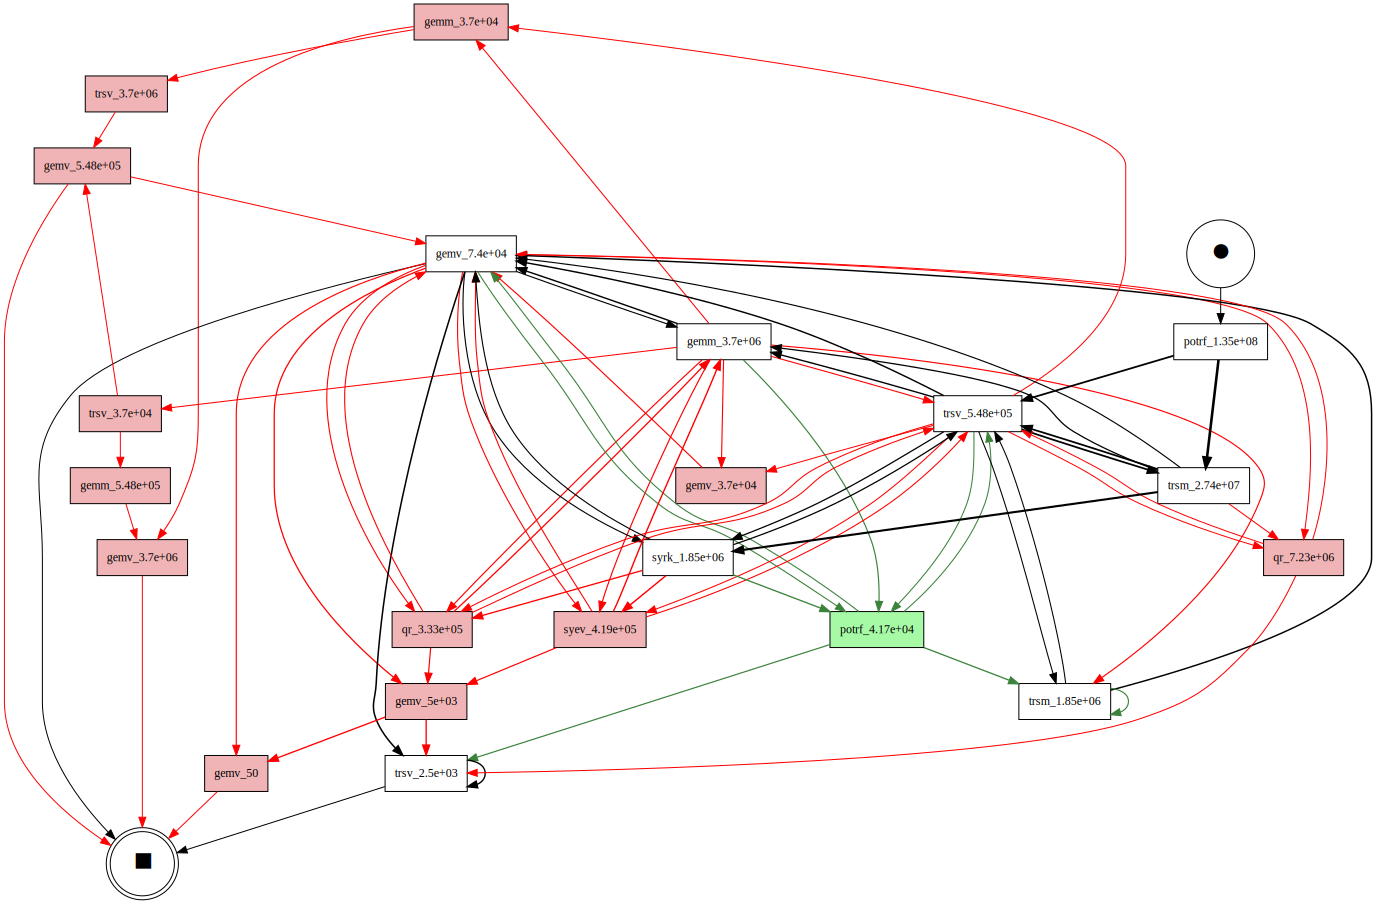

In [32]:
xvc.get_dfg_minus_best_worst()

In [33]:
_, xvc1 = rda.get_vc1('740_50')

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


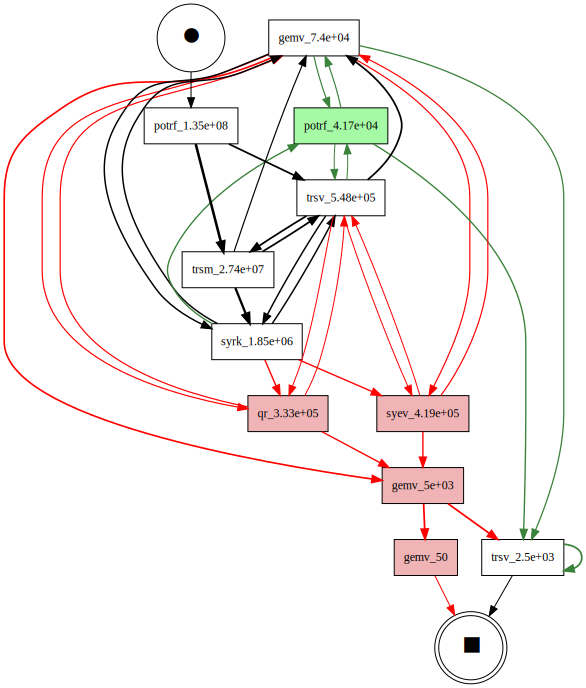

In [34]:
xvc1.get_dfg_minus_best_worst()

In [35]:
_, xvc2 = rda.get_vc2('304_247')

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


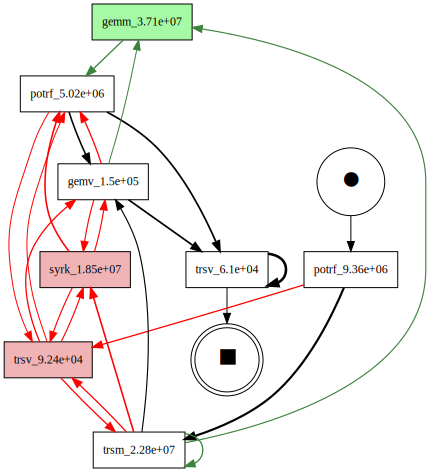

In [36]:
xvc2.get_dfg_minus_best_worst()

In [37]:
_, xvc3 = rda.get_vc3('304_247')

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


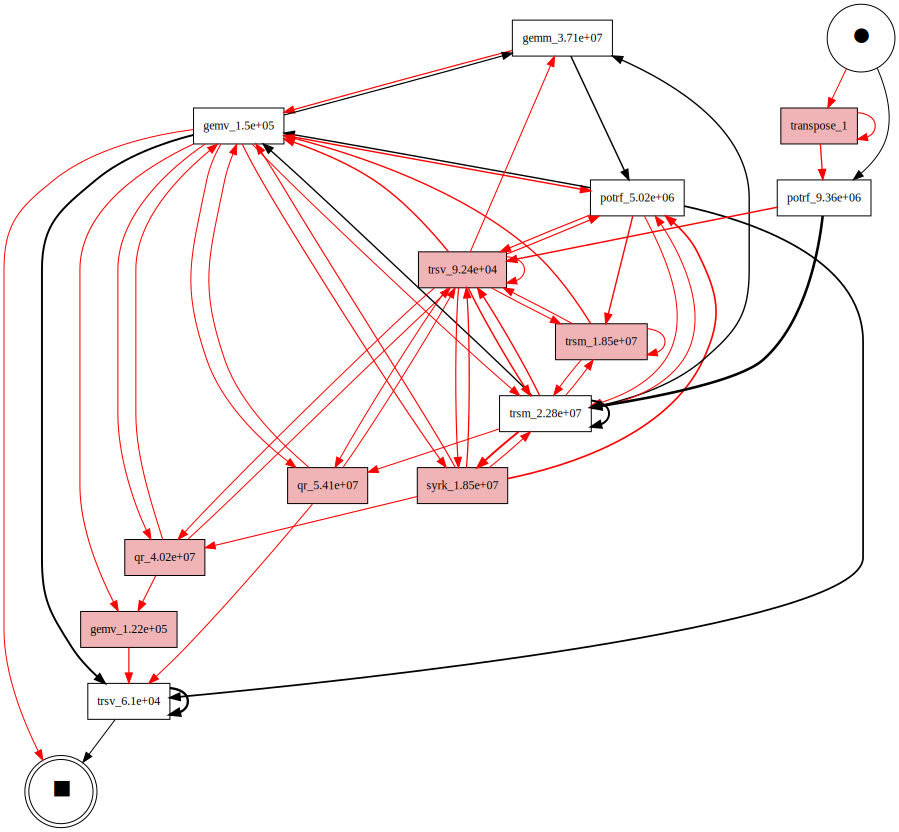

In [38]:
xvc3.get_dfg_minus_best_worst()